In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

## How to Label Rent?

Rent is the primary variable of interest, and so we would want to try and find clusters that hopefully correspond to the price of rent for the unit clusters. Rent, however, is a continuum in our dataset, so we would want to convert the continuum to discrete labels. How best to do this? We could try perfoming clustering on just the target variable to see if there are any groupings that stand out. We'll go ahead and use the same dataset as the PCA dataset.

In [2]:
ahs_2023 = pd.read_feather("../../data/AHS_2023.feather")
ahs_num = ahs_2023.select_dtypes(include=['float64', 'int64'])
ahs_num.drop(columns=['YEAR', 'FINCP', 'TOTHCAMT'], inplace=True)
ahs_num = ahs_num[ahs_num['BATHROOMS'] < 4]
ahs_num = ahs_num[ahs_num['NUMPEOPLE'] != -6]
ahs_num = ahs_num[ahs_num["RATINGNH"] != -6]
ahs_num.replace({"HOAAMT": {-6: 0}}, inplace=True)
ahs_num.dropna(inplace=True)
ahs_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19074 entries, 1 to 55664
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STORIES     19074 non-null  int64  
 1   YRBUILT     19074 non-null  int64  
 2   RENT        19074 non-null  int64  
 3   UTILAMT     19074 non-null  int64  
 4   HOAAMT      19074 non-null  float64
 5   INSURAMT    19074 non-null  int64  
 6   UNITFLOORS  19074 non-null  int64  
 7   BATHROOMS   19074 non-null  float64
 8   BEDROOMS    19074 non-null  int64  
 9   TOTROOMS    19074 non-null  int64  
 10  KITCHENS    19074 non-null  int64  
 11  DINING      19074 non-null  int64  
 12  LAUNDY      19074 non-null  int64  
 13  HINCP       19074 non-null  int64  
 14  NUMNONREL   19074 non-null  int64  
 15  NUMPEOPLE   19074 non-null  int64  
 16  HHADLTKIDS  19074 non-null  int64  
 17  HHAGE       19074 non-null  int64  
 18  HHMOVE      19074 non-null  int64  
 19  RATINGNH    19074 non-null  fl

In [ ]:
rents = ahs_num['RENT'].to_numpy()
sil_scores = []
sse = []
n_clusters = range(2, 12)
for n in n_clusters:
    clusterer = KMeans(n_clusters=n, random_state=42)
    labels = clusterer.fit_predict(rents.reshape(-1, 1))
    sil_scores.append(silhouette_score(rents.reshape(-1, 1), labels))
    sse.append(clusterer.inertia_)

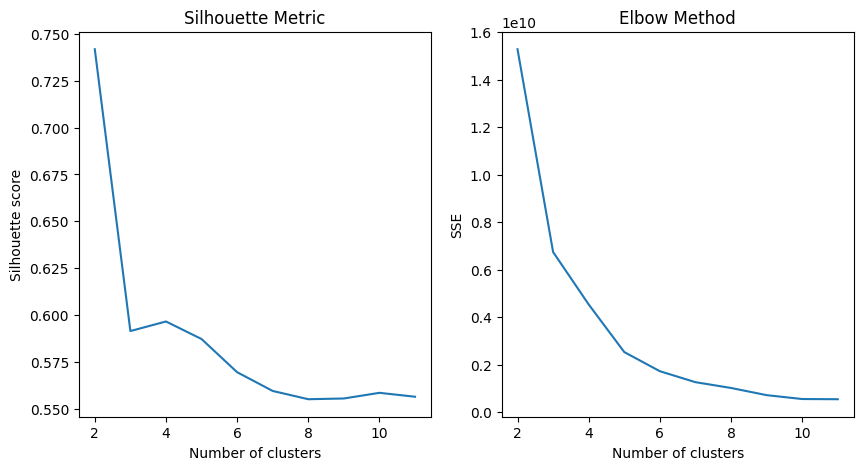

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot the silhouette scores.
ax[0].plot(n_clusters, sil_scores)
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhouette score")
ax[0].set_title("Silhouette Metric")
# Plot the SSE.
ax[1].plot(n_clusters, sse)
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("SSE")
ax[1].set_title("Elbow Method")
plt.show()

The silhouette method suggests the use of two clusters, while the elbow method appears to suggest the possible existence of five clusters (there is also a peak at four clusters in the silhouette plot, so five is perhaps plausible). We'll go ahead and store the labels for the $n=5$ clusters.

In [5]:
clusterer = KMeans(n_clusters=5, random_state=42)
labels = clusterer.fit_predict(rents.reshape(-1, 1))

## Clustering on the Numeric AHS Data

In [7]:
ahs_num_log = ahs_num.drop(columns=['RENT'])
# Log transform outlier columns.
ahs_num_log = ahs_num_log[ahs_num_log['HINCP'] >= 0]
ahs_num_log['HOAAMT'] = np.log1p(ahs_num_log['HOAAMT'])
ahs_num_log['HINCP'] = np.log1p(ahs_num_log['HINCP'])
ahs_num_log['INSURAMT'] = np.log1p(ahs_num_log['INSURAMT'])
# Scale with Standard Scaler.
scaler_log = StandardScaler()
scaler_log.fit(ahs_num_log)
ahs_scaled_log = scaler_log.transform(ahs_num_log)
scaled_log_df = pd.DataFrame(ahs_scaled_log, columns=ahs_num_log.columns)
scaled_log_df.drop(columns=["HOAAMT"], inplace=True)
ahs_scaled_log = scaled_log_df.to_numpy()

The code above isolates the dataset that has been scaled to reduce the large outlier variance and drop the HOA column, which was found to not really contain much information at all.

From the work we did performing PCA on this dataset, we know that we need to keep all of the dimensions to preserve the dataset's variance. The high dimensionality means that we cannot plot the data effectively, although we can still print the centroids and look at the results. First, we use the silhouette method to find a good number of clusters.

In [8]:
sil_scores = []
sse = []
n_clusters = range(2, 12)
for n in n_clusters:
    clusterer = KMeans(n_clusters=n, random_state=42)
    labels = clusterer.fit_predict(ahs_scaled_log)
    sil_scores.append(silhouette_score(ahs_scaled_log, labels))
    sse.append(clusterer.inertia_)

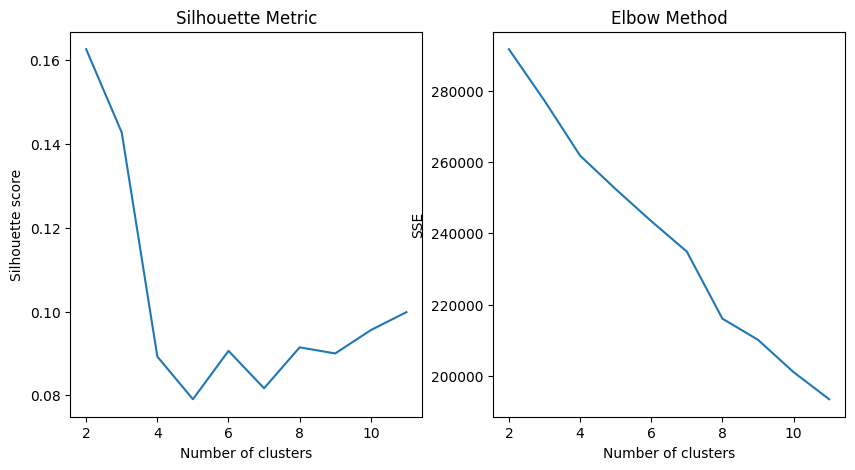

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot the silhouette scores.
ax[0].plot(n_clusters, sil_scores)
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhouette score")
ax[0].set_title("Silhouette Metric")
# Plot the SSE.
ax[1].plot(n_clusters, sse)
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("SSE")
ax[1].set_title("Elbow Method")
plt.show()

The two plots above do not inspire confidence. The Silhouette score suggests that two or three clusters are likely best, but the elbow method shows no such agreement. Not to mention that it doesn't agree at all with the results for the rents. It seems that the fears from the PCA results are borne out by the results here. K-Means doesn't seem to work well. What about density clustering?

In [ ]:
db = DBSCAN(eps = 10, min_samples = 1000, metric='euclidean').fit(ahs_scaled_log)
labels = db.labels_
# Print the estimated number of clusters.
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 159


Also not great. Suggests a single large cluster with outliers, not anything resembling the number of clusters that working with only rent produces in K-Means. Suggests that these dimensions alone are not good predictors.

## Clustering on HUD State FMR Data

For agglomerative clustering, keeping in mind we want to show a dendrogram, we'll try to use it to see if there are groups of states with different costs than others.

In [2]:
hud_metro = pd.read_csv("../../data/fmr_metro_data.csv")
hud_metro.describe()

,Year,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,FMR Percentile,smallarea_status
count,5402.000000,5402.000000,5402.000000,5402.000000,5402.000000,5402.000000,5402.000000,5402.000000
mean,2020.522399,731.228064,808.395779,1007.533876,1344.861718,1562.654757,40.072195,0.039060
std,2.294217,265.807900,296.662304,359.516927,474.345600,560.421148,0.846685,0.193755
min,2017.000000,310.000000,312.000000,389.000000,501.000000,549.000000,40.000000,0.000000
25%,2019.000000,558.000000,617.000000,785.000000,1041.000000,1189.000000,40.000000,0.000000
50%,2021.000000,658.000000,724.000000,906.000000,1219.500000,1421.500000,40.000000,0.000000
75%,2023.000000,825.000000,906.000000,1118.000000,1496.000000,1771.750000,40.000000,0.000000
max,2024.000000,2849.000000,3085.000000,4054.000000,5000.000000,5504.000000,50.000000,1.000000


In [3]:
hud_metro.head()

,Year,metro_name,code,Efficiency,One-Bedroom,Two-Bedroom,Three-Bedroom,Four-Bedroom,FMR Percentile,statename,statecode,smallarea_status
0,2017,"Anniston-Oxford-Jacksonville, AL MSA",METRO11500M11500,437,474,630,818,918,40,Alabama,AL,0
1,2017,"Auburn-Opelika, AL MSA",METRO12220M12220,543,600,798,1075,1302,40,Alabama,AL,0
2,2017,"Birmingham-Hoover, AL HUD Metro FMR Area",METRO13820M13820,665,751,866,1163,1298,40,Alabama,AL,0
3,2017,"Chilton County, AL HUD Metro FMR Area",METRO13820N01021,484,538,621,904,1094,40,Alabama,AL,0
4,2017,"Columbus, GA-AL MSA",METRO17980M17980,605,648,777,1082,1369,40,Alabama,AL,0


Isolate only 2023, since this is time-series data. Then drop percentile and smallarea.

In [4]:
hud_2023 = hud_metro[hud_metro['Year'] == 2023].copy()
hud_2023.drop(columns = ['Year', 'FMR Percentile', 'smallarea_status'], inplace=True)
# Drop unneeded non-number values.
hud_2023.drop(columns = ['code', 'statename'], inplace=True)
hud_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 685 entries, 4032 to 4716
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metro_name     685 non-null    object
 1   Efficiency     685 non-null    int64 
 2   One-Bedroom    685 non-null    int64 
 3   Two-Bedroom    685 non-null    int64 
 4   Three-Bedroom  685 non-null    int64 
 5   Four-Bedroom   685 non-null    int64 
 6   statecode      685 non-null    object
dtypes: int64(5), object(2)
memory usage: 42.8+ KB


In [5]:
hud_2023_num = hud_2023.drop(columns = ['metro_name', 'statecode'])
scaler_hud = StandardScaler()
hud_scaled = scaler_hud.fit_transform(hud_2023_num)
# PCA on HUD data.
from sklearn.decomposition import PCA
pca = PCA()
hud_pcs = pca.fit_transform(hud_scaled)

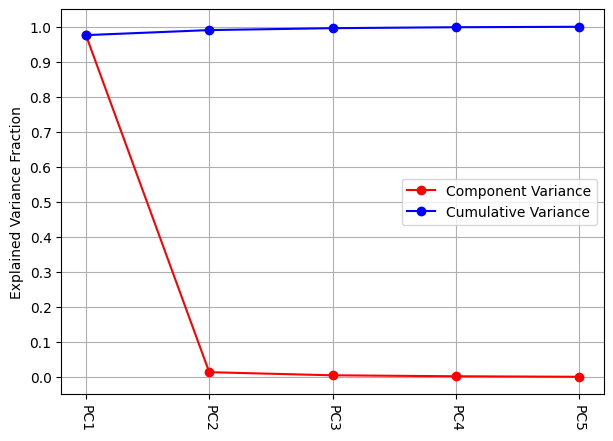

In [6]:
# Store the X and Y values we wish to plot.
exp_var = pca.explained_variance_ratio_
cols = [f"PC{i}" for i in range(1, len(exp_var) + 1)]
# Plot the explained variance of each of the components.
plt.subplots(figsize=[7,5])
plt.plot(cols, exp_var, 'ro', linestyle='solid')
plt.plot(cols, exp_var.cumsum(), 'bo', linestyle='solid')
plt.legend(labels=['Component Variance', 'Cumulative Variance'])
plt.ylabel("Explained Variance Fraction")
plt.yticks(ticks=np.linspace(0, 1, 11))
plt.xticks(rotation=-90)
plt.grid(which='major')

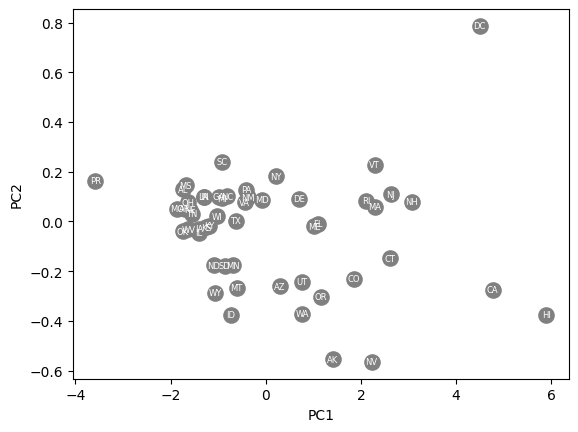

In [15]:
hud_2d = hud_scaled @ pca.components_[:2].T
hud_2d_df = pd.DataFrame(hud_2d, columns=['PC1', 'PC2'])
hud_2d_df['statecode'] = hud_2023['statecode'].to_numpy()
hud_2d_states = hud_2d_df.groupby('statecode').median().reset_index()

fig, ax = plt.subplots()
ax.scatter(hud_2d_states['PC1'], hud_2d_states['PC2'], s=120, c = 'grey')
for i, j, state in zip(hud_2d_states['PC1'],hud_2d_states['PC2'], hud_2d_states['statecode']):
    ax.annotate(state,  xy=(i, j), color='white',
                fontsize=6, weight='normal',
                horizontalalignment='center',
                verticalalignment='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [8]:
hud_2d_states.head()

,statecode,PC1,PC2
0,AK,1.406059,-0.554303
1,AL,-1.730282,0.129299
2,AR,-1.699897,0.051530
3,AZ,0.297615,-0.261125
4,CA,4.767147,-0.274932


In [16]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Copied from the numpy example at
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Perform the clustering.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean')
model = model.fit(hud_2d_states[['PC1', 'PC2']])

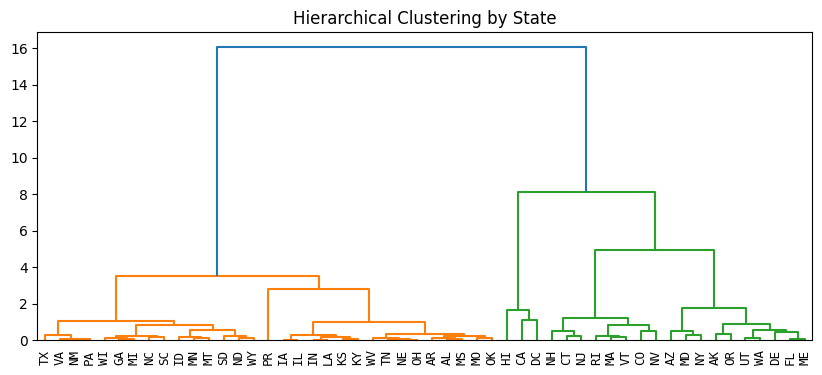

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.title("Hierarchical Clustering by State")
# plot the dendrogram
plot_dendrogram(model, labels = hud_2d_states['statecode'].to_numpy(), orientation='top', ax=ax)
ax.tick_params(axis='x', labelsize = 9, labelfontfamily = 'monospace')
plt.show()

In [18]:
sil_scores = []
sse = []
n_clusters = range(2, 10)
for n in n_clusters:
    clusterer = KMeans(n_clusters=n, random_state=42)
    labels = clusterer.fit_predict(hud_2d_states[['PC1', 'PC2']])
    sil_scores.append(silhouette_score(hud_2d_states[['PC1', 'PC2']], labels))
    sse.append(clusterer.inertia_)

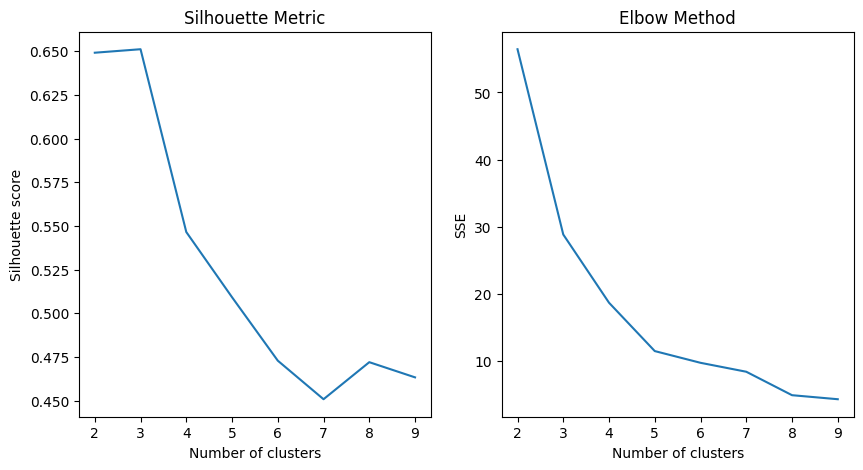

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot the silhouette scores.
ax[0].plot(n_clusters, sil_scores)
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhouette score")
ax[0].set_title("Silhouette Metric")
# Plot the SSE.
ax[1].plot(n_clusters, sse)
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("SSE")
ax[1].set_title("Elbow Method")
plt.show()

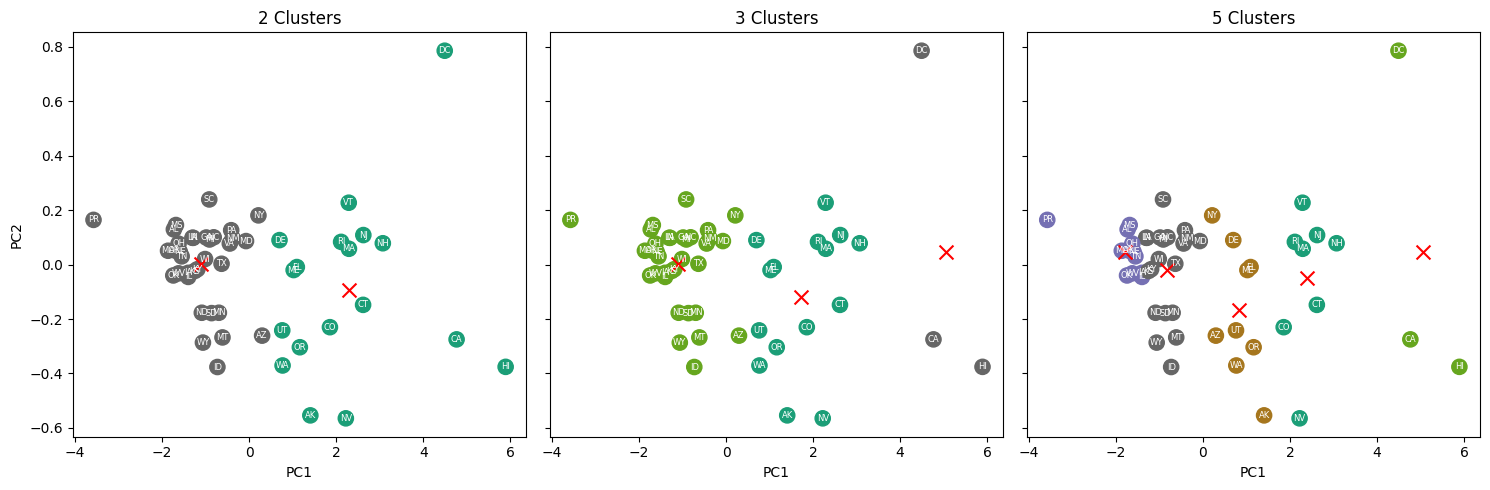

In [20]:
# Plot the k-means results for 2, 3, and 5 clusters.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for x, n in enumerate([2, 3, 5]):
    # Find the labels using KMeans with the given number of clusters.
    clusterer = KMeans(n_clusters=n, random_state=42)
    labels = clusterer.fit_predict(hud_2d_states[['PC1', 'PC2']])
    # Plot the points colored by the identified clusters.
    scatter = ax[x].scatter(hud_2d_states['PC1'], hud_2d_states['PC2'], c = labels, s = 120, cmap='Dark2')
    # Set the title of the plot indicating the number of clusters.
    ax[x].set_title(f"{n} Clusters")
    # Annotate each point with the state code.
    for i, j, state in zip(hud_2d_states['PC1'],hud_2d_states['PC2'], hud_2d_states['statecode']):
        ax[x].annotate(state,  xy=(i, j), color='white',
                    fontsize=6, weight='normal',
                    horizontalalignment='center',
                    verticalalignment='center')
    # Plot the cluster centers.
    ax[x].scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1], c='red', s=100, marker='x')
    # Remove the y axis label for all but the first plot.
    if x > 0:
        ax[x].set_yticklabels([])
    # Add the x axis label.
    ax[x].set_xlabel("PC1")
    # Require tight layout.
    fig.set_tight_layout(True)
# Add the y-axis label to the leftmost plot.
ax[0].set_ylabel("PC2")
# Show the plot.
plt.show()

In [33]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = 0.5, min_samples = 5, metric='euclidean').fit(hud_2d_states[['PC1', 'PC2']])
labels = db.labels_
# Print the estimated number of clusters.
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 6


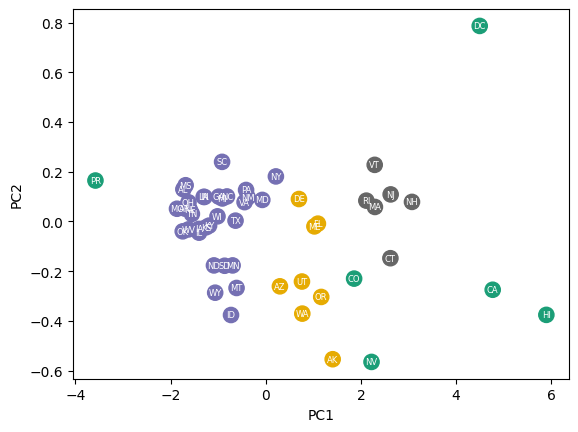

In [34]:
fig, ax = plt.subplots()
scatter = ax.scatter(hud_2d_states['PC1'], hud_2d_states['PC2'], c = db.labels_, s = 120, cmap='Dark2')
#legend1 = ax.legend(*scatter.legend_elements(),
#                    loc="best", title="Classes")
#ax.add_artist(legend1)

for i, j, state in zip(hud_2d_states['PC1'],hud_2d_states['PC2'], hud_2d_states['statecode']):
    ax.annotate(state,  xy=(i, j), color='white',
                fontsize=6, weight='normal',
                horizontalalignment='center',
                verticalalignment='center')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()